In [1]:
import os,glob
import numpy as np
import pandas as pd
import glob
import pyslha
import time
from matplotlib import pyplot as plt


delphesDir = os.path.abspath("../DelphesHSCP")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

Welcome to JupyROOT 6.24/06


True

In [2]:
# inputFile = '../test.root'
inputFile = '../Stau_0j_match/Events/run_01/stau_400_10.00ns_delphes_events.root'
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()
# nevts = 3
towerParticlesR = []
towerParticlesZ = []
for ievt in range(nevts):    

    tree.GetEntry(ievt)        

    metCalo = tree.MissingETCalo.At(0)
    dmParticles = [tree.dmParticles.At(idm) for idm in range(tree.dmParticles.GetEntries())]
    dmPDGs = set([dm.PID for dm in dmParticles])

    

    for itower in range(tree.Tower.GetEntries()):
        tower = tree.Tower.At(itower)
        for ip in range(tower.Particles.GetEntries()):
            p = tower.Particles.At(ip)
            towerParticlesR.append(np.sqrt(p.X**2 + p.Y**2))    
            towerParticlesZ.append(np.sqrt(p.Z**2))
    

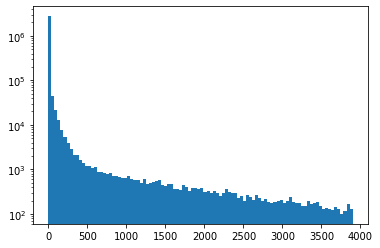

In [3]:
plt.hist(towerParticlesR,bins=100)
plt.yscale('log')
plt.show()

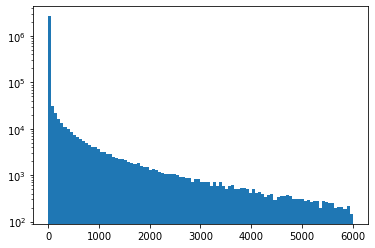

In [5]:
plt.hist(towerParticlesZ,bins=100)
plt.yscale('log')
plt.show()

In [6]:
max(towerParticlesR),max(towerParticlesZ)

(3899.8431429077964, 5999.93359375)

In [7]:
pTtot = np.array([0.,0.])
ETtot = 0.0
for itower in range(tree.Tower.GetEntries()):
    tower = tree.Tower.At(itower)
    ETtot += tower.ET
    pTtot += np.array([tower.ET*np.cos(tower.Phi),tower.ET*np.sin(tower.Phi)])
    

In [8]:
ETtot,np.sqrt(pTtot[0]**2+pTtot[1]**2),metCalo.MET

(221.02741847280413, 37.43902350081925, 37.439022064208984)

In [9]:
print(pTtot[0],pTtot[1])
print(metCalo.MET*np.cos(metCalo.Phi),metCalo.MET*np.sin(metCalo.Phi))

21.555695125699398 -30.610986399376216
-21.55569578006794 30.610984181523605


In [10]:
towerParticles = []
for itower in range(tree.Tower.GetEntries()):
    tower = tree.Tower.At(itower)
    for ip in range(tower.Particles.GetEntries()):
        p = tower.Particles.At(ip)
        towerParticles.append(p)

In [11]:
finalHSCPDaughters = []
for i in range(tree.isoHSCPs.GetEntries()):
    p = tree.isoHSCPs.At(i)
    print(p.PID)

1000015
-1000015


In [12]:
finalHSCPDaughters = []
for i in range(tree.hscpDaughters.GetEntries()):
    p = tree.hscpDaughters.At(i)
    print(p.PID)

15
1000039
-15
1000039


In [13]:
def getDaughters(p):
    if p.Status == 1:
        return []
    daughters = [tree.Particle.At(d) for d in range(p.D1,p.D2+1)]
    return daughters

stableDaughters = []
for i in range(tree.Particle.GetEntries()):
    p = tree.Particle.At(i)
    if abs(p.PID) not in [2000015,1000015]:
        continue
    if p.D1 == p.D2:
        continue
    daughters = getDaughters(p)
    unstable = []
    for d in daughters:
        if d.Status == 1:
            stableDaughters.append(d)
        else:
            unstable.append(d)
    while len(unstable) > 0:
        daughters = []
        for d in unstable:
            daughters += getDaughters(d)
        unstable = []
        for d in daughters:
            if d.Status == 1:
                stableDaughters.append(d)
            else:
                unstable.append(d)
    

In [21]:
print(len(stableDaughters))
for d in stableDaughters:
    print(d.PID,d.Status,d.PT,np.sqrt(d.X**2 + d.Y**2),np.abs(d.Z),d.Eta)

9
22 1 5.6935416381520554e-08 1448.8411284606602 1230.7181396484375 -1.2144017219543457
1000039 1 397.4970397949219 1448.8411284606602 1230.7181396484375 -0.4917527735233307
16 1 51.47553253173828 1450.9878586460713 1234.5655517578125 -0.8181523680686951
13 1 70.23114013671875 1450.9878586460713 1234.5655517578125 -0.8196094632148743
-14 1 83.60552978515625 1450.9878586460713 1234.5655517578125 -0.8218570351600647
1000039 1 85.2042236328125 1780.05945147528 4435.95263671875 -2.185584783554077
-16 1 200.39602661132812 1867.3604668527614 4584.142578125 -1.292176365852356
-11 1 94.72628021240234 1867.3604668527614 4584.142578125 -1.284305214881897
12 1 234.2896728515625 1867.3604668527614 4584.142578125 -1.2885730266571045


In [17]:
for d in towerParticles:
    if d.PID not in [22,16,-211,211,12,-11,-16,11,12,-12,13,-13]:
        continue
#     if d.PT < 0.02: continue
    if np.sqrt(d.X**2 + d.Y**2) < 100.0: continue
    print(d.PID,d.PT,d.Eta,np.sqrt(d.X**2 + d.Y**2))

-11 94.72628021240234 -1.284305214881897 1867.3604668527614
-211 0.05413650721311569 -4.335975170135498 129.64927379169282
-211 1.0950117111206055 -2.036285400390625 151.18095261333104


In [20]:
for d in towerParticles:
    if d.PID not in [11,-11]: continue
    print(d.PID,d.PT,d.Eta)

-11 94.72628021240234 -1.284305214881897
11 0.17232050001621246 1.9722315073013306
